# COVID-19 Detection Using Multi-Phase Training of ConvNets with Multi-Class Imbalanced Chest CT Scan Data

The main sections of the notebook are:

1. [Import Needed Libraries](#a)
2. [Logistic Regression](#b)
3. [Training with smotesampled Data](#c)
4. [Two-Phase Training with Undersampling](#d)
5. [Multi-Phase Training with Undersampling](#e)

<div style="text-align: right"> Ahmet Talha Yiğit / 507191101 </div>

<a id=’a’></a>
### 1. Import Needed Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,classification_report
from sklearn.metrics import average_precision_score,PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit,GridSearchCV
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE 
from imblearn.combine import SMOTEENN

# Import needed packages for the model building and stage
#from skimage import io, transform
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils       
from torchvision.utils import make_grid
import torch.optim as optim

c:\Users\ahmet\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def lift_scorer(target, pred_proba):
    
    df = pd.DataFrame(pred_proba)
    df.columns = ['pred_proba']
    df['target'] = target.values
    df['pred_proba_rank'] = df['pred_proba'].rank(ascending = False).astype(int)
    lift = round(df[df['pred_proba_rank'] <= round(df['pred_proba_rank'].max() * (1/100), 0)]['target'].sum() / df['target'].sum() * 100, 1)

    return lift

In [3]:
X_train = pd.read_pickle('./Data/X_train_preprocessed.pkl')
y_train = pd.read_pickle('./Data/y_train_preprocessed.pkl')
X_val = pd.read_pickle('./Data/X_val_preprocessed.pkl')
y_val = pd.read_pickle('./Data/y_val_preprocessed.pkl')
X_test = pd.read_pickle('./Data/X_test_preprocessed.pkl')
y_test = pd.read_pickle('./Data/y_test_preprocessed.pkl')

In [4]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000,), (7500, 33), (7500,), (7500, 33), (7500,))

In [5]:
X_train = X_train.reset_index()
y_train = y_train.reset_index()
X_val = X_val.reset_index()
y_val = y_val.reset_index()
X_test = X_test.reset_index()
y_test = y_test.reset_index()

X_train['idx'] = 'Train'
y_train['idx'] = 'Train'
X_val['idx'] = 'Val'
y_val['idx'] = 'Val'
X_test['idx'] = 'Test'
y_test['idx'] = 'Test'

X_train['index'] = X_train['index'].astype('str')
y_train['index'] = y_train['index'].astype('str')
X_val['index'] = X_val['index'].astype('str')
y_val['index'] = y_val['index'].astype('str')
X_test['index'] = X_test['index'].astype('str')
y_test['index'] = y_test['index'].astype('str')

X_train['index'] = X_train[["index", "idx"]].apply("-".join, axis=1)
y_train['index'] = y_train[["index", "idx"]].apply("-".join, axis=1)
X_val['index'] = X_val[["index", "idx"]].apply("-".join, axis=1)
y_val['index'] = y_val[["index", "idx"]].apply("-".join, axis=1)
X_test['index'] = X_test[["index", "idx"]].apply("-".join, axis=1)
y_test['index'] = y_test[["index", "idx"]].apply("-".join, axis=1)

X_train = X_train.set_index('index')
y_train = y_train.set_index('index')
X_val = X_val.set_index('index')
y_val = y_val.set_index('index')
X_test = X_test.set_index('index')
y_test = y_test.set_index('index')

X_train = X_train.drop('idx', axis = 1)
y_train = y_train.drop('idx', axis = 1)
X_val = X_val.drop('idx', axis = 1)
y_val = y_val.drop('idx', axis = 1)
X_test = X_test.drop('idx', axis = 1)
y_test = y_test.drop('idx', axis = 1)

In [6]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 33), (60000, 1), (7500, 33), (7500, 1), (7500, 33), (7500, 1))

In [7]:
X_train.head()

,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,...,Var_27,Var_28,Var_30,Var_31,Var_33,Var_34,Var_36,Var_38,Var_39,Var_41
index,,,,,,,,,,,,,,,,,,,,,
60075-Train,-0.109742,1.134404,-1.009085,-3.644704,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,...,-0.144079,-0.247141,-0.249080,0.240094,-0.396241,-1.289230,-0.039831,-0.345385,-0.233373,-0.006544
27225-Train,-0.109742,0.075986,0.977945,-0.731477,-1.627865,-0.470549,0.480831,0.641715,0.194911,0.634267,...,-0.144079,-0.247141,-0.249080,0.240094,0.533820,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
403-Train,-0.109742,0.075986,0.702450,-0.631123,0.562187,-0.470549,0.480831,0.641715,0.194911,0.634267,...,0.063240,-0.247141,4.014773,0.240094,2.491077,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
27953-Train,-0.109742,-0.408430,0.702450,1.045385,0.613346,-0.470549,0.480831,0.641715,0.194911,0.634267,...,0.063240,-0.247141,-0.249080,0.240094,0.169018,0.640053,-0.039831,-0.345385,-0.233373,-0.006544
74481-Train,-0.109742,-0.408430,0.702450,0.077261,1.008509,1.183906,0.480831,0.641715,0.194911,-1.576622,...,-0.144079,0.475470,-0.249080,0.240094,0.455636,0.640053,-0.039831,-0.345385,-0.233373,-0.006544


<a id=’b’></a>
## 2. DQN

In [16]:
y_train_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_train_predict.pkl')
y_val_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_val_predict.pkl')
y_test_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_test_predict.pkl')
y_train_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_train_predict_proba.pkl')
y_val_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_val_predict_proba.pkl')
y_test_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_test_predict_proba.pkl')

In [18]:
accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned)
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned)
print('R&T Model:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tlift:', round(lift_score,4))

R&T Model: 	accuracy: 0.9737 	precision: 0.1039 	recall: 0.2133 	f1: 0.1397 	roc_auc: 0.3521 	lift: 16.0


In [19]:
cm_resampled_tuned = confusion_matrix(y_val,y_val_predict_resampled_tuned) #Create a confusion matrix of GT labels and predictions
print('----------------------------------------------------------------------------------')
print('CM Resampled & Tuned')
print(cm_resampled_tuned)
print('----------------------------------------------------------------------------------')

----------------------------------------------------------------------------------
CM Resampled & Tuned
[[7287  138]
 [  59   16]]
----------------------------------------------------------------------------------


In [23]:
y_train_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_train_predict.pkl')
y_val_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_val_predict.pkl')
y_test_predict_resampled_tuned = pd.read_pickle('./RL predictions/y_test_predict.pkl')
y_train_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_train_predict_proba.pkl')
y_val_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_val_predict_proba.pkl')
y_test_predict_proba_resampled_tuned = pd.read_pickle('./RL predictions/y_test_predict_proba.pkl')

Plot DQN curves of Resampled & Tuned Model:


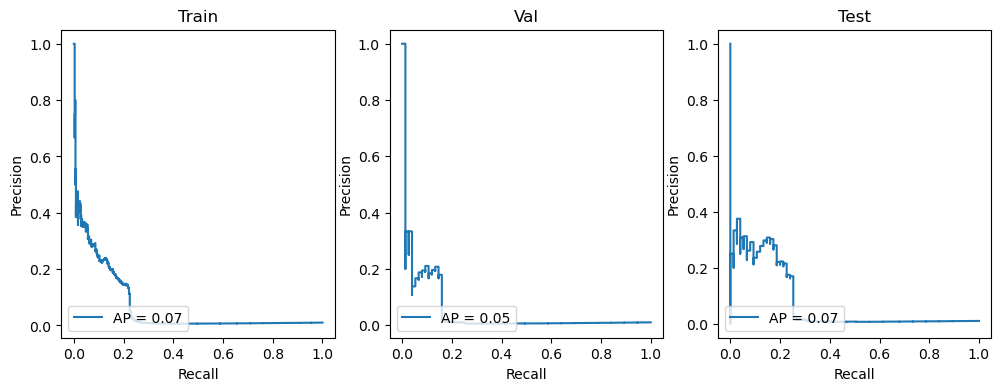

PR_AUC Train: 0.068 	| PR_AUC Val: 0.051 	| PR_AUC Test: 0.0744


In [24]:
print('Plot DQN curves of Resampled & Tuned Model:')

fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_predict_proba_resampled_tuned)
AP_train = average_precision_score(y_train, y_train_predict_proba_resampled_tuned)
PR_curve_train = PrecisionRecallDisplay(precision_train, recall_train, average_precision = AP_train)
ax1.set_title("Train")
PR_curve_train.plot(ax1)
plt.subplot(1, 3, 2)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_val_predict_proba_resampled_tuned)
AP_val = average_precision_score(y_val, y_val_predict_proba_resampled_tuned)
PR_curve_val = PrecisionRecallDisplay(precision_val, recall_val, average_precision = AP_val)
ax2.set_title("Val")
PR_curve_val.plot(ax2)
plt.subplot(1, 3, 3)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_predict_proba_resampled_tuned)
AP_test = average_precision_score(y_test, y_test_predict_proba_resampled_tuned)
PR_curve_test = PrecisionRecallDisplay(precision_test, recall_test, average_precision = AP_test)
ax3.set_title("Test")
PR_curve_test.plot(ax3)
plt.show()

print('PR_AUC Train:', round(AP_train, 4),'\t| PR_AUC Val:', round(AP_val, 4),'\t| PR_AUC Test:', round(AP_test, 4))

In [25]:
accuracy = accuracy_score(y_train,y_train_predict_resampled_tuned)
precision = precision_score(y_train,y_train_predict_resampled_tuned)
recall = recall_score(y_train,y_train_predict_resampled_tuned)
f1 = f1_score(y_train,y_train_predict_resampled_tuned)
roc_auc = roc_auc_score(y_train,y_train_predict_proba_resampled_tuned)
pr_auc = average_precision_score(y_train, y_train_predict_proba_resampled_tuned)
lift_score = lift_scorer(y_train, y_train_predict_proba_resampled_tuned)
print('R&T Model Train:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_val,y_val_predict_resampled_tuned)
precision = precision_score(y_val,y_val_predict_resampled_tuned)
recall = recall_score(y_val,y_val_predict_resampled_tuned)
f1 = f1_score(y_val,y_val_predict_resampled_tuned)
roc_auc = roc_auc_score(y_val,y_val_predict_proba_resampled_tuned)
pr_auc = average_precision_score(y_val, y_val_predict_proba_resampled_tuned)
lift_score = lift_scorer(y_val, y_val_predict_proba_resampled_tuned)
print('R&T Model Val:', '\t\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

accuracy = accuracy_score(y_test,y_test_predict_resampled_tuned)
precision = precision_score(y_test,y_test_predict_resampled_tuned)
recall = recall_score(y_test,y_test_predict_resampled_tuned)
f1 = f1_score(y_test,y_test_predict_resampled_tuned)
roc_auc = roc_auc_score(y_test,y_test_predict_proba_resampled_tuned)
pr_auc = average_precision_score(y_test, y_test_predict_proba_resampled_tuned)
lift_score = lift_scorer(y_test, y_test_predict_proba_resampled_tuned)
print('R&T Model Test:', '\taccuracy:', round(accuracy,4), '\tprecision:', round(precision,4), '\trecall:', round(recall,4), '\tf1:', round(f1,4), '\troc_auc:', round(roc_auc,4), '\tpr_auc:', round(pr_auc,4), '\tlift_score:', round(lift_score,4))

R&T Model Train: 	accuracy: 0.974 	precision: 0.1242 	recall: 0.265 	f1: 0.1691 	roc_auc: 0.3953 	pr_auc: 0.068 	lift_score: 17.2
R&T Model Val: 		accuracy: 0.9737 	precision: 0.1039 	recall: 0.2133 	f1: 0.1397 	roc_auc: 0.3521 	pr_auc: 0.051 	lift_score: 16.0
R&T Model Test: 	accuracy: 0.9727 	precision: 0.1264 	recall: 0.2933 	f1: 0.1767 	roc_auc: 0.4308 	pr_auc: 0.0744 	lift_score: 21.3
